Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Training a 3D Diffusion Model for Generating 3D Images with Various Sizes and Spacings

![Generated image examples](https://developer-blogs.nvidia.com/wp-content/uploads/2024/06/image3.png)

In this notebook, we detail the procedure for training a 3D latent diffusion model to generate high-dimensional 3D medical images. Due to the potential for out-of-memory issues on most GPUs when generating large images (e.g., those with dimensions of 512 x 512 x 512 or greater), we have structured the training process into two primary steps: 1) generating image embeddings and 2) training 3D latent diffusion models. The subsequent sections will demonstrate the entire process using a simulated dataset.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
%matplotlib inline

## Setup imports

In [2]:
import copy
import os
import json
import numpy as np
import nibabel as nib
from IPython.display import Image, display
import glob
import torch

from monai.apps import download_url
from monai.data import create_test_image_3d
from monai.config import print_config
from monai.apps import download_and_extract
from monai.transforms import LoadImage, Orientation

from scripts.diff_model_setting import setup_logging, run_torchrun
from scripts.download_model_data import download_model_data
from scripts.diff_model_create_training_data import diff_model_create_training_data
from scripts.diff_model_train import diff_model_train
from scripts.diff_model_infer import diff_model_infer
from scripts.utils_plot import find_label_center_loc, get_xyz_plot, show_image

print_config()

logger = setup_logging("notebook")
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "max_split_size_mb:128,expandable_segments:True")

MONAI version: 1.5.1+4.g69f3dd26
Numpy version: 2.2.6
Pytorch version: 2.9.0+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 69f3dd26ed2a65e89ae89d951bb16f2dcb4d7c5d
MONAI __file__: /localhome/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 12.0.0
Tensorboard version: 2.20.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.24.0+cu128
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.1.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOW

'max_split_size_mb:128,expandable_segments:True'

## Set up the MAISI version

Choose among `'ddpm-ct'`, `'rflow-ct'`, and `'rflow-mr'`. The differences are:
- The version `'ddpm-ct'` and `'rflow-ct'` generate CT images, while `'rflow-mr'` generate MR images.
- The version `'ddpm-ct'` uses basic noise scheduler DDPM. `'rflow-ct'` and `'rflow-mr'`use Rectified Flow scheduler, can be 33 times faster during inference.
- The version `'ddpm-ct'` requires training images to be labeled with body region (`"top_region_index"` and `"bottom_region_index"`), while `'rflow-ct'` does not have such requirement. In other words, it is easier to prepare training data.
- For the released model weights, `'rflow-ct'` can generate images with better quality for head region and small output volumes, and comparable quality for other cases compared with `'ddpm-ct'`.

In [3]:
generate_version = "rflow-ct"
if generate_version == "ddpm-ct":
    model_def_path = "./configs/config_network_ddpm.json"
elif generate_version == "rflow-ct" or generate_version == "rflow-mr":
    model_def_path = "./configs/config_network_rflow.json"
else:
    raise ValueError(f"generate_version has to be chosen from ['ddpm-ct', 'rflow-ct', 'rflow-mr'], yet got {generate_version}.")
with open(model_def_path, "r") as f:
    model_def = json.load(f)
include_body_region = model_def["include_body_region"]
logger.info(f"Models are {generate_version}, whether to use body_region is {include_body_region}")

[2025-10-26 01:35:48.510][ INFO](notebook) - Models are rflow-ct, whether to use body_region is False


## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.

In [4]:
os.environ["MONAI_DATA_DIRECTORY"] = "./temp_work_dir"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

download_model_data(generate_version,root_dir,model_only = True)

saved to: ['models/autoencoder_v1.pt']
saved to: ['models/mask_generation_autoencoder.pt']
saved to: ['models/mask_generation_diffusion_unet.pt']
saved to: ['models/diff_unet_3d_rflow-ct.pt']
saved to: ['models/controlnet_3d_rflow-ct.pt']


## Build training dataset

In [5]:
demo_train_data_rootdir = os.path.join(root_dir, "demo_train_datasets")
if 'ct' in generate_version:
    demo_train_data_modality = 'ct'
    # MSD Spleen CT data
    resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
    md5 = "410d4a301da4e5b2f6f86ec3ddba524e"    
    
    compressed_file = os.path.join(demo_train_data_rootdir, "Task09_Spleen.tar")
    dataset_name = "Task09_Spleen"
    data_path = os.path.join(demo_train_data_rootdir, dataset_name)
    if not os.path.exists(data_path):
        download_and_extract(resource, compressed_file, demo_train_data_rootdir, md5)
    
    # Only include 5 of the images for quick demo purpose
    train_images = sorted(glob.glob(os.path.join(data_path, "imagesTr", "*.nii.gz")))[:5]
    data_dicts = [
        {"image": os.path.relpath(image_name, demo_train_data_rootdir), "modality": demo_train_data_modality} 
        for image_name in train_images
    ]
    len_train = int(0.8 * len(data_dicts))
    train_files, val_files = data_dicts[:len_train], data_dicts[len_train:]
elif 'mr' in generate_version:
    demo_train_data_modality = 'mri_t1'
    # MSD Brats MRI data
    resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar"
    md5 = "240a19d752f0d9e9101544901065d872"
    
    compressed_file = os.path.join(demo_train_data_rootdir, "Task01_BrainTumour.tar")
    dataset_name = "Task01_BrainTumour"
    data_path = os.path.join(demo_train_data_rootdir, dataset_name)
    if not os.path.exists(data_path):
        download_and_extract(resource, compressed_file, demo_train_data_rootdir, md5)
    
    # Only include 6 of the images for quick demo purpose
    train_images = sorted(glob.glob(os.path.join(data_path, "imagesTr", "*.nii.gz")))[:6]

    # Extract 2th channel of each image to create single-channel MRI data
    dataset_name = dataset_name+"_t1"
    new_data_path = data_path.replace("Task01_BrainTumour",dataset_name)
    for img_path in train_images:
        img = nib.load(img_path)
        # Use dataobj to avoid loading entire array unless needed
        data = np.asanyarray(img.dataobj)
        affine = img.affine
        header = img.header.copy()
    
        if data.ndim != 4:
            logger.info(f"{img_path} is not 4D.")
            continue
        else:
            out_path = img_path.replace(data_path, new_data_path)
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
    
        # Heuristic: detect channel dim (first vs last)
        # If either first or last dim is small (2–8), treat that as channels.
        first, last = data.shape[0], data.shape[-1]
        if last < 4:
            raise ValueError(f"{img_path} has only {last} channels; need at least 4.")
        vol_t1 = data[..., 1]

        # Ensure a standard dtype; float32 is fine for most workflows
        vol_t1 = np.asarray(vol_t1, dtype=np.float32)
    
        
        out_img = nib.Nifti1Image(vol_t1, affine, header)
        nib.save(out_img, out_path)
        print(f"Saved: {out_path}")

    
    data_dicts = [
        {"image": os.path.relpath(image_name.replace(data_path, new_data_path), demo_train_data_rootdir), "modality": demo_train_data_modality} 
        for image_name in train_images
    ]
    data_path = new_data_path
    len_train = int(0.8 * len(data_dicts))
    train_files, val_files = data_dicts[:len_train], data_dicts[len_train:]

## Generate data list json

[2025-10-26 01:35:48.539][ INFO](notebook) - Visualize training image ./temp_work_dir/demo_train_datasets/Task09_Spleen/imagesTr/spleen_10.nii.gz
/localhome/local-pengfeig/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.array Orientation.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


Train image shape torch.Size([1, 512, 512, 55])


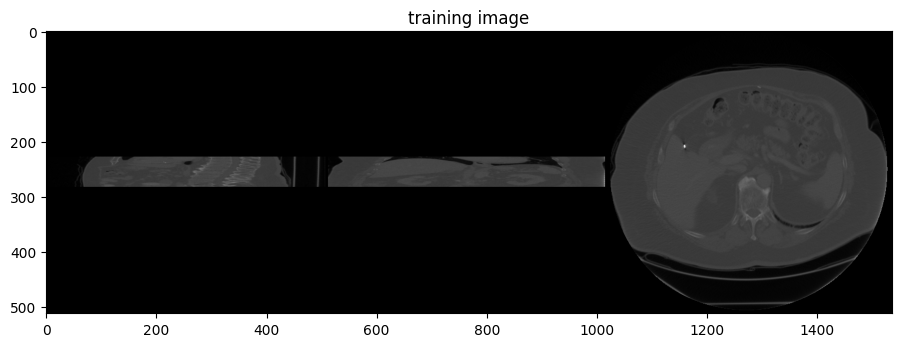

In [6]:
dataset_list = {"training": train_files, "testing": val_files}
datalist_file = os.path.join(root_dir, "sim_datalist.json")
with open(datalist_file, "w") as f:
    json.dump(dataset_list, f)

## Visualize the data
visualize_image_filename = os.path.join(demo_train_data_rootdir,dataset_list["training"][0]["image"])
logger.info(f"Visualize training image {visualize_image_filename}")
# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

print(f"Train image shape {image_volume.shape}")
center_loc_axis = find_label_center_loc(image_volume.squeeze(0))
vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="training image")

### Set up directories and configurations

To optimize the demonstration for time efficiency, we have adjusted the training epochs to 2. Additionally, we modified the `num_splits` parameter in [AutoencoderKlMaisi](https://github.com/Project-MONAI/MONAI/blob/dev/monai/apps/generation/maisi/networks/autoencoderkl_maisi.py#L881) from its default value of 16 to 4. This adjustment reduces the spatial splitting of feature maps in convolutions, which is particularly beneficial given the smaller input size. (This change helps convert convolutions to a for-loop based approach, thereby conserving GPU memory resources.)

In [7]:
env_config_path = f"./configs/environment_maisi_diff_model_{generate_version}.json"
model_config_path = f"./configs/config_maisi_diff_model_{generate_version}.json"

# Load environment configuration, model configuration and model definition
with open(env_config_path, "r") as f:
    env_config = json.load(f)

with open(model_config_path, "r") as f:
    model_config = json.load(f)

env_config_out = copy.deepcopy(env_config)
model_config_out = copy.deepcopy(model_config)
model_def_out = copy.deepcopy(model_def)

# Set up directories based on configurations
env_config_out["data_base_dir"] = demo_train_data_rootdir
env_config_out["embedding_base_dir"] = os.path.join(root_dir, env_config_out["embedding_base_dir"])
env_config_out["json_data_list"] = datalist_file
env_config_out["model_dir"] = os.path.join(root_dir, env_config_out["model_dir"])
env_config_out["output_dir"] = os.path.join(root_dir, env_config_out["output_dir"])
trained_autoencoder_path = env_config_out["trained_autoencoder_path"]

# Create necessary directories
os.makedirs(env_config_out["embedding_base_dir"], exist_ok=True)
os.makedirs(env_config_out["model_dir"], exist_ok=True)
os.makedirs(env_config_out["output_dir"], exist_ok=True)

env_config_filepath = os.path.join(root_dir, "environment_maisi_diff_model.json")
with open(env_config_filepath, "w") as f:
    json.dump(env_config_out, f, sort_keys=True, indent=4)

# Update model configuration for demo
max_epochs = 2
model_config_out["diffusion_unet_train"]["n_epochs"] = max_epochs

model_config_filepath = os.path.join(root_dir, "config_maisi_diff_model.json")
with open(model_config_filepath, "w") as f:
    json.dump(model_config_out, f, sort_keys=True, indent=4)

# Update model definition for demo
model_def_out["autoencoder_def"]["num_splits"] = 2
model_def_filepath = os.path.join(root_dir, "config_maisi.json")
with open(model_def_filepath, "w") as f:
    json.dump(model_def_out, f, sort_keys=True, indent=4)

# Print files and folders under root_dir
logger.info(f"files and folders under root_dir: {os.listdir(root_dir)}.")

# Adjust based on the number of GPUs you want to use
num_gpus = 1
logger.info(f"number of GPUs: {num_gpus}.")

[2025-10-26 01:35:51.044][ INFO](notebook) - files and folders under root_dir: ['.ipynb_checkpoints', 'sim_datalist.json', 'output', 'environment_maisi_diff_model.json', 'demo_train_datasets', 'config_maisi.json', '.cache', 'models', 'datasets', 'config_maisi_diff_model.json', 'embeddings'].
[2025-10-26 01:35:51.045][ INFO](notebook) - number of GPUs: 1.


## Step 1: Create Training Data

To train the latent diffusion model, we first store the latent features produced by the autoencoder's encoder in local storage. This allows the latent diffusion model to directly utilize these features, thereby conserving both time and GPU memory during the training process. Additionally, we have provided the script for multi-GPU processing to save latent features from all training images, significantly accelerating the creation of the entire training set.

The diffusion model utilizes a U-shaped convolutional neural network architecture, requiring matching input and output dimensions. Therefore, it is advisable to resample the input image dimensions to be multiples of 2 for compatibility. In this case, we have chosen dimensions that are multiples of 128.

In [8]:
logger.info("Creating training data...")

# Define the arguments for torchrun
module_args = {
    "env_config_path": env_config_filepath,
    "model_config_path": model_config_filepath,
    "model_def_path": model_def_filepath,
    "num_gpus": num_gpus
}
logger.info(module_args)

diff_model_create_training_data(**module_args)

[2025-10-26 01:35:51.050][ INFO](notebook) - Creating training data...
[2025-10-26 01:35:51.051][ INFO](notebook) - {'env_config_path': './temp_work_dir/environment_maisi_diff_model.json', 'model_config_path': './temp_work_dir/config_maisi_diff_model.json', 'model_def_path': './temp_work_dir/config_maisi.json', 'num_gpus': 1}
[2025-10-26 01:35:51.452][ INFO](creating training data) - Using device cuda:0
[2025-10-26 01:35:51.852][ INFO](creating training data) - filenames_raw: [{'image': 'Task09_Spleen/imagesTr/spleen_10.nii.gz', 'modality': 'ct'}, {'image': 'Task09_Spleen/imagesTr/spleen_12.nii.gz', 'modality': 'ct'}, {'image': 'Task09_Spleen/imagesTr/spleen_13.nii.gz', 'modality': 'ct'}, {'image': 'Task09_Spleen/imagesTr/spleen_14.nii.gz', 'modality': 'ct'}]
/localhome/local-pengfeig/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R

Generate embeddings assuming data modality is ct
Generate embeddings assuming data modality is ct
Generate embeddings assuming data modality is ct
Generate embeddings assuming data modality is ct


### Create .json files for embedding files

The diffusion model necessitates additional input attributes, including output dimension, output spacing, and top/bottom body region. These dimensions and spacing can be extracted from the header information of the training images. The top and bottom body region inputs can be determined through manual examination or by utilizing segmentation masks from tools such as [TotalSegmentator](https://github.com/wasserth/TotalSegmentator) or [MONAI VISTA](https://github.com/Project-MONAI/VISTA). The body regions are formatted as 4-dimensional one-hot vectors: the head and neck region is represented by [1,0,0,0], the chest region by [0,1,0,0], the abdomen region by [0,0,1,0], and the lower body region (below the abdomen) by [0,0,0,1]. The additional input attributes are saved in a separate .json file. In the following example, we assume that the images cover the chest and abdomen regions.

In [9]:
def list_gz_files(folder_path):
    """List all .gz files in the folder and its subfolders."""
    gz_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".gz"):
                gz_files.append(os.path.join(root, file))
    return gz_files


def create_json_files(gz_files, modality):
    """Create .json files for each .gz file with the specified keys and values."""
    for gz_file in gz_files:
        # Load the NIfTI image
        img = nib.load(gz_file)

        # Get the dimensions and spacing
        dimensions = img.shape
        dimensions = dimensions[:3]
        spacing = img.header.get_zooms()[:3]
        spacing = spacing[:3]
        spacing = [float(_item) for _item in spacing]

        # Create the dictionary with the specified keys and values
        data = {"dim": dimensions, "spacing": spacing, "modality": modality}
        if include_body_region:
            # The region can be selected from one of four regions from top to bottom.
            # [1,0,0,0] is the head and neck, [0,1,0,0] is the chest region, [0,0,1,0]
            # is the abdomen region, and [0,0,0,1] is the lower body region.
            data["top_region_index"] = [0, 1, 0, 0]  # chest region
            data["bottom_region_index"] = [0, 0, 1, 0]  # abdomen region
        logger.info(f"data: {data}.")

        # Create the .json filename
        json_filename = gz_file + ".json"

        # Write the dictionary to the .json file
        with open(json_filename, "w") as json_file:
            json.dump(data, json_file, indent=4)
        logger.info(f"Save json file to {json_filename}")


folder_path = os.path.join(env_config_out["embedding_base_dir"],dataset_name)
gz_files = list_gz_files(folder_path)
create_json_files(gz_files, demo_train_data_modality)

logger.info("Completed creating .json files for all embedding files.")

[2025-10-26 01:36:00.724][ INFO](notebook) - data: {'dim': (128, 128, 32), 'spacing': [0.9765620231628418, 0.9765620231628418, 2.1484375], 'modality': 'ct'}.
[2025-10-26 01:36:00.725][ INFO](notebook) - Save json file to ./temp_work_dir/./embeddings/Task09_Spleen/imagesTr/spleen_10_emb.nii.gz.json
[2025-10-26 01:36:00.727][ INFO](notebook) - data: {'dim': (128, 128, 32), 'spacing': [0.8515620231628418, 0.8515620231628418, 2.109375], 'modality': 'ct'}.
[2025-10-26 01:36:00.728][ INFO](notebook) - Save json file to ./temp_work_dir/./embeddings/Task09_Spleen/imagesTr/spleen_14_emb.nii.gz.json
[2025-10-26 01:36:00.730][ INFO](notebook) - data: {'dim': (128, 128, 32), 'spacing': [0.7421879768371582, 0.7421879768371582, 1.50390625], 'modality': 'ct'}.
[2025-10-26 01:36:00.731][ INFO](notebook) - Save json file to ./temp_work_dir/./embeddings/Task09_Spleen/imagesTr/spleen_13_emb.nii.gz.json
[2025-10-26 01:36:00.733][ INFO](notebook) - data: {'dim': (128, 128, 32), 'spacing': [0.75390601158142

## Step 2: Train the Model

After all latent features have been created, we will initiate the multi-GPU script to train the latent diffusion model.

The image generation process utilizes the [DDPM scheduler](https://arxiv.org/pdf/2006.11239) with 1,000 iterative steps. The diffusion model is optimized using L1 loss and a decayed learning rate scheduler. The batch size for this process is set to 1.

Please be aware that using the H100 GPU may occasionally result in random segmentation faults. To avoid this issue, you can disable AMP by setting the `--no_amp` flag.

In [10]:
logger.info("Training the model...")

# Define the arguments for torchrun
module_args = {
    "env_config_path": env_config_filepath,
    "model_config_path": model_config_filepath,
    "model_def_path": model_def_filepath,
    "num_gpus": num_gpus,
    "amp": True
}

diff_model_train(**module_args)

[2025-10-26 01:36:00.740][ INFO](notebook) - Training the model...
[2025-10-26 01:36:00.743][ INFO](training) - Using cuda:0 of 1
[2025-10-26 01:36:00.743][ INFO](training) - [config] ckpt_folder -> ./temp_work_dir/./models.
[2025-10-26 01:36:00.744][ INFO](training) - [config] data_root -> ./temp_work_dir/./embeddings.
[2025-10-26 01:36:00.745][ INFO](training) - [config] data_list -> ./temp_work_dir/sim_datalist.json.
[2025-10-26 01:36:00.745][ INFO](training) - [config] lr -> 1e-05.
[2025-10-26 01:36:00.746][ INFO](training) - [config] num_epochs -> 2.
[2025-10-26 01:36:00.746][ INFO](training) - [config] num_train_timesteps -> 1000.
[2025-10-26 01:36:03.874][ INFO](training) - Pretrained checkpoint ./models/diff_unet_3d_rflow-ct.pt loaded.
[2025-10-26 01:36:03.954][ INFO](training) - num_files_train: 4
[2025-10-26 01:36:04.429][ INFO](training) - Scaling factor set to 1.0952297449111938.
[2025-10-26 01:36:04.431][ INFO](training) - scale_factor -> 1.0952297449111938.
/localhome/loc

## Step 3: Infer using the Trained Model

Upon completing the training of the latent diffusion model, we can employ the multi-GPU script to perform inference. By integrating the diffusion model with the autoencoder's decoder, this process will generate 3D images with specified top/bottom body regions, spacing, and dimensions.

In [11]:
logger.info("Running inference...")

# Define the arguments for torchrun
module_args = {
    "env_config_path": env_config_filepath,
    "model_config_path": model_config_filepath,
    "model_def_path": model_def_filepath,
    "num_gpus": num_gpus
}

saved_filepath = diff_model_infer(**module_args)

logger.info("Completed all steps.")

[2025-10-26 01:36:15.555][ INFO](notebook) - Running inference...
[2025-10-26 01:36:15.562][ INFO](inference) - Using cuda:0 of 1 with random seed: 0
[2025-10-26 01:36:15.562][ INFO](inference) - [config] ckpt_filepath -> ./temp_work_dir/./models/diff_unet_3d_rflow-ct.pt.
[2025-10-26 01:36:15.563][ INFO](inference) - [config] random_seed -> 0.
[2025-10-26 01:36:15.564][ INFO](inference) - [config] output_prefix -> unet_3d.
[2025-10-26 01:36:15.564][ INFO](inference) - [config] output_size -> (256, 256, 128).
[2025-10-26 01:36:15.565][ INFO](inference) - [config] out_spacing -> (1.7, 1.7, 2).
[2025-10-26 01:36:15.566][ INFO](root) - `controllable_anatomy_size` is not provided.
[2025-10-26 01:36:17.883][ INFO](inference) - checkpoints ./temp_work_dir/./models/diff_unet_3d_rflow-ct.pt loaded.
[2025-10-26 01:36:17.884][ INFO](inference) - scale_factor -> 1.0952297449111938.
[2025-10-26 01:36:17.886][ INFO](inference) - num_downsample_level -> 4, divisor -> 4.
[2025-10-26 01:36:17.889][ INF

## Visualize the results

The checkpoint here is finetuned on pretrained model for only a few steps, so the result will not be similar to the training data used in this tutorial.

[2025-10-26 01:36:32.448][ INFO](notebook) - Visualizing ./temp_work_dir/./output/unet_3d_seed0_size256x256x128_spacing1.70x1.70x2.00_20251026013631_rank0_modality1.nii.gz...


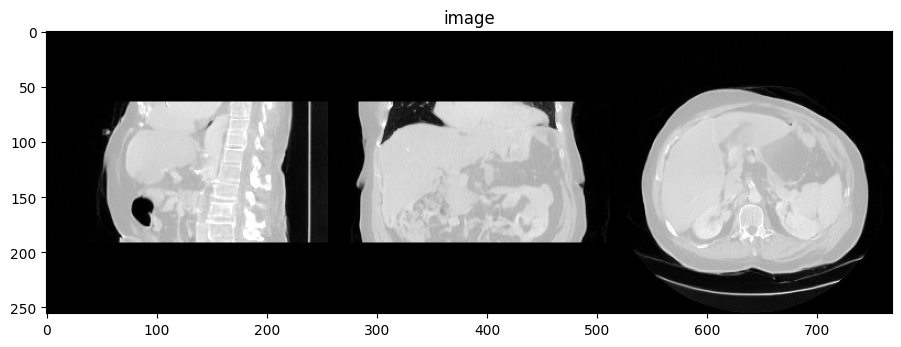

In [12]:
visualize_image_filename = saved_filepath[0]
logger.info(f"Visualizing {visualize_image_filename}...")

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))

# visualize for CT HU intensity between [-200, 500]
if generate_version == "rflow-mr":
    image_volume = torch.clip(image_volume, 0, 1000)
else:
    image_volume = torch.clip(image_volume, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(image_volume[0,...], [-3, -2, -1]))

# visualization
vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")